## 2.4.4. Make your own regression model

<em>From previous assignment.. </em>
<blockquote>Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:
    
$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$
</blockquote>

Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import math

In [2]:
path = ("/Users/gemma/Documents/data science/DS bootcamp/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv"
            )
df = pd.read_csv(path, delimiter= ',', encoding='latin-1',header=0)


In [3]:
# getting names of columns to access them more easily
# and renaming murder because the name is messy

colnames = df.columns.values
print(colnames)

# renamed it originally but later on wasn't necessary bc i dropped the columns
#df.rename({'Murder and\nnonnegligent\nmanslaughter' : 'Murder etc'}, axis='columns', inplace=True)


['City' 'Population' 'Violent\ncrime'
 'Murder and\nnonnegligent\nmanslaughter' 'Rape\n(revised\ndefinition)1'
 'Rape\n(legacy\ndefinition)2' 'Robbery' 'Aggravated\nassault'
 'Property\ncrime' 'Burglary' 'Larceny-\ntheft' 'Motor\nvehicle\ntheft'
 'Arson3']


In [4]:
df.head(3)


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0


A glimpse at the data

In [5]:
# adding binary features - murder (or robbery) > 0 = 1, else 0

df['Murder bin'] = np.where(df[colnames[3]]==0, 0, 1)
df['Robbery bin'] = np.where(df['Robbery'] == 0, 0, 1)
df['Aggravated asault bin'] = np.where(df['Aggravated\nassault'] == 0,0,1)

In [6]:
df.head(3)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Murder bin,Robbery bin,Aggravated asault bin
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0,0,1,1
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0,0,1,1
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0,0,1,1


Taking another look at the data after adding categorical features for Murder, Robbery, and Aggravated assault

In [7]:
# making the data frame i'll use for the regression

crime = df.drop(labels=colnames[2:8], axis=1)
crime.drop(labels=colnames[10:13], axis=1, inplace=True)

In [8]:
# renaming the weirdly named columns

crime.rename({'Murder bin': 'Murder', 'Robbery bin':'Robbery', 
              'Property\ncrime': 'Property crime', 'Aggravated asault bin': 'A. assault'}, axis='columns',inplace=True)


In [9]:
# cleaning up population and property crime 

num_cleanup = ['Population', 'Property crime','Burglary'] 

# there's at least one cell (in Population) with just a space, so filling blanks with NaN
crime = crime.replace(r'^\s*$', np.nan, regex=True)

# now dropping the row(s) that contain(s) the nan 
crime.dropna(axis=0, how='any', inplace=True)

# dropping commas and making integers

def cleanup(data_fr, numeric_str):
    # getting rid of commas
    data_fr[numeric_str] = data_fr[numeric_str].apply(lambda x: ''.join(list(filter(str.isdigit, str(x)))))

    # finally! the series is an integer (checked in the cell below)
    data_fr[numeric_str] = data_fr[numeric_str].astype(int)
    
    return

for one in num_cleanup:
    cleanup(crime, one)

# double checking
crime.dtypes


City              object
Population         int64
Property crime     int64
Burglary           int64
Murder             int64
Robbery            int64
A. assault         int64
dtype: object

Double checking the conversion of the columns to integers worked correctly

In [10]:
crime.head(3)

,City,Population,Property crime,Burglary,Murder,Robbery,A. assault
0,Adams Village,1861,12,2,0,1,1
1,Addison Town and Village,2577,24,3,0,1,1
2,Akron Village,2846,16,1,0,1,1


Separated the features and target into a new table to focus on them instead of working with all of the data at once

In [11]:
# adding pop ^2 bc i didnt do that yet

crime.insert(2, 'Popˆ2', crime['Population']**2, allow_duplicates=False)

In [12]:
crime.head(3)

,City,Population,Popˆ2,Property crime,Burglary,Murder,Robbery,A. assault
0,Adams Village,1861,3463321,12,2,0,1,1
1,Addison Town and Village,2577,6640929,24,3,0,1,1
2,Akron Village,2846,8099716,16,1,0,1,1


Added the feature "Population squared" as required for the initial formula

In [13]:
# holdout groups

data = crime[['Population','Popˆ2','Murder','Robbery','Burglary']]
target = crime['Property crime'] 

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)

regr = linear_model.LinearRegression()

print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data, target).score(data, target)))

With 20% Holdout: -432.986060179
Testing on Sample: 0.999576580943


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Running the model with just the basic initial features, using 20% holdout. It looks like there might be overfitting due to the 99%% on the sample, and the strange holdout number.

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, data, target, cv=10)



array([   0.938554  ,    0.98519169,    0.84341985,    0.89958785,
          0.89559403,    0.93098549, -299.41182903,    0.99072378,
          0.99333016,    0.79445254])

Also tried to run cross validation with the same data, to see very mixed results.

In [15]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime['Property crime'].values.reshape(-1, 1)
X = crime[['Population','Popˆ2','Murder','Robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  3.42007759e-02  -2.05708444e-09  -9.55478272e+00   0.00000000e+00]]

Intercept: 
 [-156.63730133]

R-squared:
0.996092290373


Running the model to see the r squared and all of the coefficients

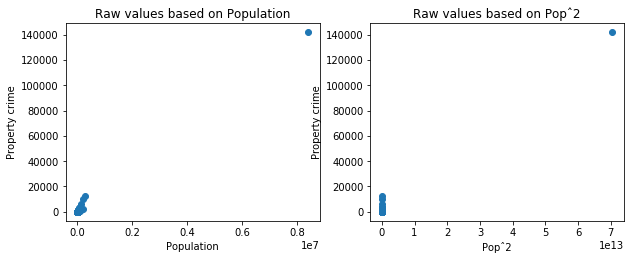

In [16]:
# checking if the data fits the assumtion of being linear...

labels = ['Population', 'Popˆ2']
Y = crime['Property crime'].values.reshape(-1, 1)

#,'Murder','Robbery']  #theyre binary so this is silly

plt.figure(figsize=(10,8))

for i, label in enumerate(labels):

    plt.subplot(2,2,i+1)
    plt.scatter(crime[label], Y)
    plt.xlabel(label)
    plt.ylabel('Property crime')
    plt.title('Raw values based on {}'.format(label))

plt.show()

Checking for linearity in the features of population and population squared compared to proprety crime.

From the plots, it looks like there is an outlier. I wanted to find what it was, in order to remove it from the model and prevent skewed data. Below, first i am finding the value of the outlier, and in the next cell, I am determining which city it is associated with. Finally, I am dropping it from the dataframe.

In [17]:
# looks like there's an outlier skewing the results

max(crime['Property crime'].unique().tolist())

141971

In [18]:
# finding where the outlier is

crime[crime['Property crime'] == 141971]

,City,Population,Popˆ2,Property crime,Burglary,Murder,Robbery,A. assault
216,New York,8396126,70494931807876,141971,16606,1,1,1


In [19]:
# dropping it

crime.drop([216], inplace=True)

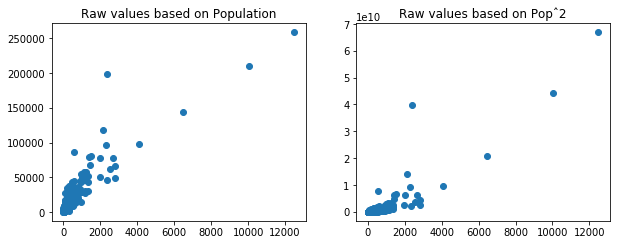

In [20]:
# to check again for linearity of data

plt.figure(figsize=(10,8))

for i, label in enumerate(labels):

    plt.subplot(2,2,i+1)
    plt.scatter(crime['Property crime'].values.reshape(-1, 1), crime[label])
    plt.title('Raw values based on {}'.format(label))

plt.show()

After removing the outlier, I checked the linearity again of these two features. It is much easier to see them without the outlier, and they look for the most part linear, although they could use a little improvement.

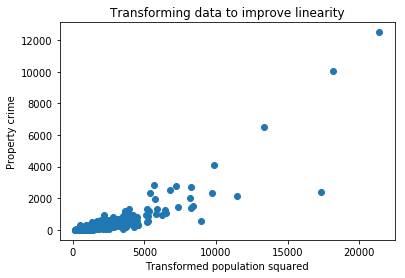

In [21]:
def myformula(value):
    return value**.4

crime['popˆ2 ftd'] = crime['Popˆ2'].apply(myformula)

plt.scatter(crime['popˆ2 ftd'],  crime['Property crime'].values.reshape(-1, 1))
plt.title('Transforming data to improve linearity')
plt.xlabel('Transformed population squared')
plt.ylabel('Property crime')
plt.show()

Above and below, I am trying different formulas to make the population and population squared more linear.

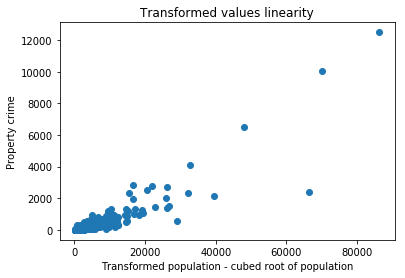

In [22]:
def my2ndform(value):
#    return 1/math.sqrt(math.log(value))
#    return math.sqrt(value**3)
    return value**1/3
    

crime['log pop ftd'] = crime['Population'].apply(my2ndform)

plt.scatter(crime['log pop ftd'],  crime['Property crime'].values.reshape(-1, 1))
plt.title('Transformed values linearity')
plt.xlabel('Transformed population - cubed root of population')
plt.ylabel('Property crime')
plt.show()

In [23]:
crime.head(4)

,City,Population,Popˆ2,Property crime,Burglary,Murder,Robbery,A. assault,popˆ2 ftd,log pop ftd
0,Adams Village,1861,3463321,12,2,0,1,1,412.854572,620.333333
1,Addison Town and Village,2577,6640929,24,3,0,1,1,535.662859,859.000000
2,Akron Village,2846,8099716,16,1,0,1,1,579.946480,948.666667
3,Albany,97956,9595377936,4090,705,1,1,1,9836.143001,32652.000000


Above, looking at the table with the transformed variables

In [24]:
# trying to figure out the error below
print(len(crime[['Population','popˆ2 ftd']]))

actual = crime['Property crime']

print(len(actual))

347
347


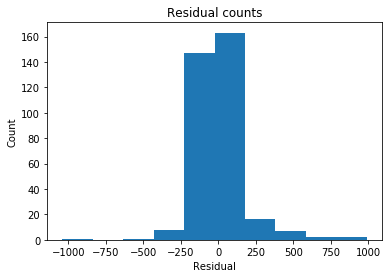

In [25]:

X4 = crime[['Population', 'Murder', 'Burglary', 'log pop ftd' ]]
actual2 = crime['Property crime']
#.values.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(X4, actual)


# Extract predicted values.
predicted2 = regr.predict(X4).ravel()


# Calculate the error, also called the residual.
residual2 = actual2 - predicted2

# This looks a bit concerning.
plt.hist(residual2)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
#plt.ylim([-100, 100])
#plt.xlim([-7800,7800])
plt.show()

Reviewing the residual counts with the transformed data and the features that impact the model the most

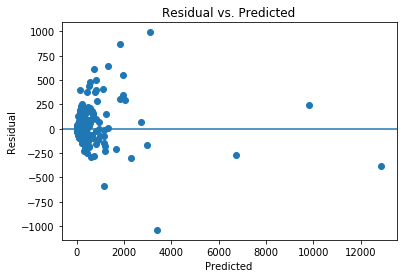

In [26]:
plt.scatter(predicted2, residual2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


Looking at the residual vs predicted values variance

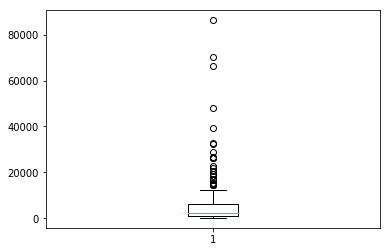

In [27]:
plt.boxplot(crime['log pop ftd'])
plt.show()

This is another look at the variance, paying attention to the outliers and the general range

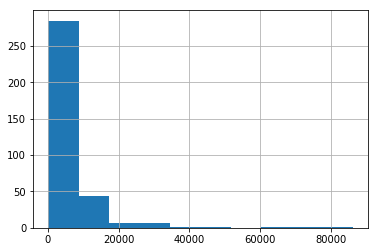

In [28]:
crime['log pop ftd'].hist()

A histogram of the transformed population variable

In [29]:
# w/ holdout groups
target2 = crime['Property crime']
data2 = crime[['log pop ftd','Popˆ2', 'Murder', 'Burglary', 'A. assault']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2, random_state=20)

print('With 20% Holdout: ' + str(regr.fit(X_train2, y_train2).score(X_test2, y_test2)))
print('Testing on Sample: ' + str(regr.fit(data2, target2).score(data2, target2)))



With 20% Holdout: 0.915567815582
Testing on Sample: 0.97998629566


Trying the model with the improved features. It looks like it is much better, because the holdout % is much closer to the value on the test sample.

In [30]:
# cross val

cross_val_score(regr, data2,target2, cv=10)

array([ 0.94964727,  0.99059232,  0.86100859,  0.91270335,  0.87278346,
        0.89533255,  0.92000959,  0.99090159,  0.97473812,  0.86255387])

Also trying to cross validate the score. It also looks like the model is much improved over the original version.

In [31]:
regr = linear_model.LinearRegression()
Y3 = crime['Property crime'].values.reshape(-1, 1)
X3 = crime[['log pop ftd','Popˆ2','Murder','Robbery', 'A. assault','Burglary']]
regr.fit(X3, Y3)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X3, Y3))


Coefficients: 
 [[  4.03675097e-02  -3.42580633e-08  -4.40121251e+01   0.00000000e+00
    0.00000000e+00   3.29364091e+00]]

Intercept: 
 [-26.80892086]

R-squared:
0.97998629566


Above, the model is run in full again and shows the coefficients in addition to the r squared value and the intercept.

In [32]:
max(set(crime['Population'].tolist()))

258789/4

64697.25

Looking at the population values in order to improve the chart below, and see the data more clearly.

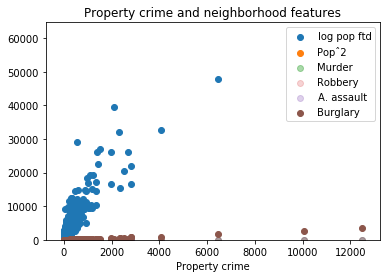

In [33]:
plt.scatter(crime['Property crime'], crime['log pop ftd'])
plt.scatter(crime['Property crime'], crime['Popˆ2'])
plt.scatter(crime['Property crime'], crime['Murder'], alpha=0.4)
plt.scatter(crime['Property crime'], crime['Robbery'], alpha=0.2)
plt.scatter(crime['Property crime'], crime['A. assault'], alpha=0.3)
plt.scatter(crime['Property crime'], crime['Burglary'])
plt.legend()
plt.xlabel('Property crime')
plt.title('Property crime and neighborhood features')
plt.ylim([0,64697])
plt.show()


I wanted to look at the variance of the features and variables that I selected, to see which ones were most significant in the model. The population squared doesn't show up on this chart becasue I narrowed the y range too much, in order to get a better view of the other variables.

In [34]:
correlation_matrix = X3.corr()
display(correlation_matrix)


,log pop ftd,Popˆ2,Murder,Robbery,A. assault,Burglary
log pop ftd,1.000000,0.888582,0.502713,NaN,NaN,0.819673
Popˆ2,0.888582,1.000000,0.344873,NaN,NaN,0.892961
Murder,0.502713,0.344873,1.000000,NaN,NaN,0.401800
Robbery,NaN,NaN,NaN,NaN,NaN,NaN
A. assault,NaN,NaN,NaN,NaN,NaN,NaN
Burglary,0.819673,0.892961,0.401800,NaN,NaN,1.000000


Taking a look at the correlation matrix to get numeric vlaues for what's visible in the chart above. It looks like robbery and aggravated assault don't add anything significant to the model, whereas burglary does seem to be significant to the model, as well as the transofmred population variable, and murder.

###  The feature engineering and selection process

Inititally I used the features from the previous assignment - population, population squared, murder (a binary/ categorical indicator) and robbery (another binary/ categorical indictaor) and used that information in my first attempt at a linear regression model.

The first model's R value was 84, and the y intercept was 18, which means that the model predicts accurately in about 84% of cases, and there is an assumption of about 18 property crimes at a minimum. 

In an effort to increase the accuracy of the model, I tried to make sure all of the variables/ features had linear relationships with the amount of property crime by transforming variables where necessary, fix each feature for normality, use categorical features to account for heteroscedasticity, and removed the most extreme outlier of proprety crime, which was skewing the data.

After cleaning the data, transforming the features to fit the above described assumptions of linear regression, and re-attempting the linear regression model, the R value was 83.6, and the y-intercept was 2536. Because the R value actually decreased slightly, it appears that the feature transformation didn't actually improve the linear regression model. Based on this, it appears like the initital linear regression model was more accurate and more useful in practice.